In [9]:
!where python
%pip install ucimlrepo

/Users/khaspper/anaconda3/bin/python
/Users/khaspper/anaconda3/bin/python
Note: you may need to restart the kernel to use updated packages.


In [10]:
# This tells the NB to keep an eye on the other Python files I import so if i change them pyter will automatically reload the latest version so we do not have to manually re-import stuff
%load_ext autoreload 

# This means it's gonna reload everything everytime I run a cell 
%autoreload 2

# This tells Jupyter to show graphs and charts inside the notebook instead of popping up in separate windows
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import ast

In [18]:
# Load dataset
df = pd.read_csv('./archive/movies_metadata.csv', low_memory=False)

# Drop unused columns
df = df.drop(columns=[
    'adult', 'belongs_to_collection', 'homepage', 'id', 'imdb_id', 'original_title',
    'overview', 'poster_path', 'production_companies', 'production_countries',
    'spoken_languages', 'status', 'tagline', 'title', 'video'
])

# Convert types
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')
df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce')
df['vote_count'] = pd.to_numeric(df['vote_count'], errors='coerce')
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')
df['vote_average'] = pd.to_numeric(df['vote_average'], errors='coerce')
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Drop rows with missing values
df_clean = df.dropna()

# Extract release year
df_clean['release_year'] = df_clean['release_date'].dt.year

# Drop release_date
df_clean = df_clean.drop(columns=['release_date'])

# Parse genres
def parse_genres(genre_str):
    try:
        genre_list = ast.literal_eval(genre_str)
        return [g['name'] for g in genre_list]
    except:
        return []

df_clean['genre_names'] = df_clean['genres'].apply(parse_genres)
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(df_clean['genre_names']),
                             columns=mlb.classes_,
                             index=df_clean.index)
df_clean = pd.concat([df_clean, genre_encoded], axis=1)
df_clean = df_clean.drop(columns=['genres', 'genre_names'])

/var/folders/03/32qzbx8j6fgfw2pmsk_tt4bm0000gn/T/ipykernel_16284/3933131037.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['release_year'] = df_clean['release_date'].dt.year


In [13]:
# One-hot encode original_language
lang_dummies = pd.get_dummies(df_clean['original_language'], prefix='lang')
df_clean = pd.concat([df_clean, lang_dummies], axis=1)
df_clean = df_clean.drop(columns=['original_language'])

# Normalize numeric features
target = 'vote_average'  # Change to 'popularity' if predicting popularity
features_to_normalize = ['budget', 'revenue', 'runtime', 'vote_count', 'release_year']
if target == 'popularity':
    features_to_normalize.append('vote_average')
else:
    features_to_normalize.append('popularity')

scaler = StandardScaler()
df_clean[features_to_normalize] = scaler.fit_transform(df_clean[features_to_normalize])

# Split into X and y
X = df_clean.drop(columns=[target])
y = df_clean[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
# Train Random Forest
model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print("Mean Squared Error:", mse)
print("R² Score:", r2)


Mean Squared Error: 1.195508988585993
R² Score: 0.6684458878269117


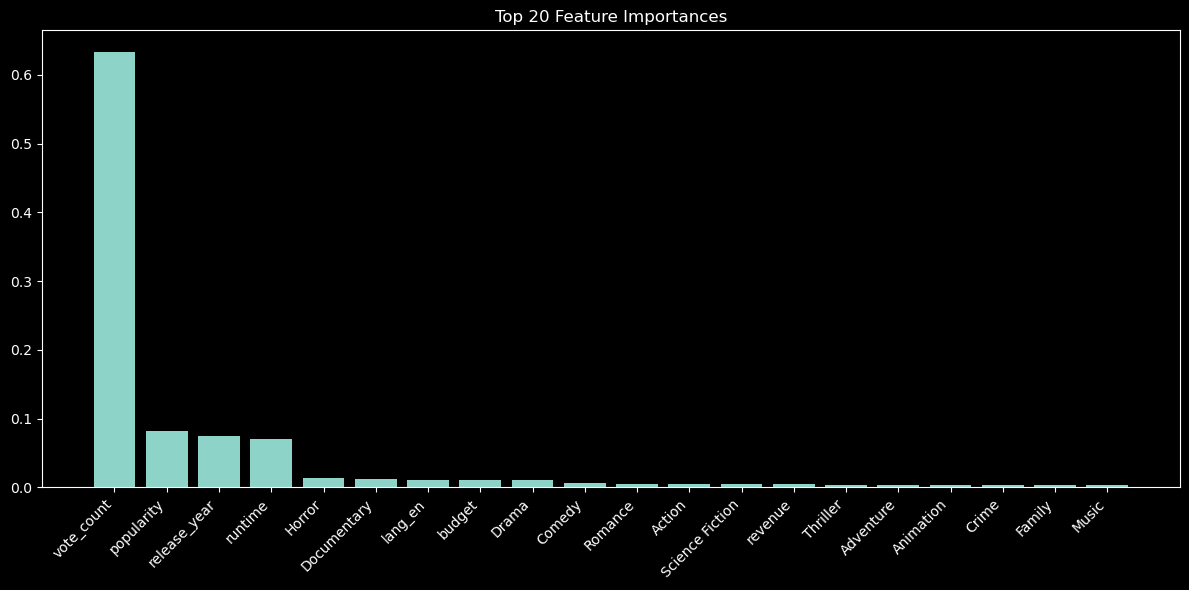

In [15]:
# Plot feature importance
plt.style.use('dark_background')

# Plot top 20 feature importances
importances = model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Top 20 Feature Importances")
plt.bar(range(20), importances[indices[:20]], align="center")
plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=45, ha="right")
plt.tight_layout()
plt.show()